In [373]:
import warnings
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", RuntimeWarning)

from collections import Counter
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score

In [292]:
title_fontdict = {
  'fontsize': 16,
  'fontweight': 'bold',
  'fontfamily': 'monospace'
}

pct_fontdict = {
  'fontsize': 14,
  'fontweight': 'bold',
  'fontfamily': 'monospace'
}

In [293]:
def outliers(df, n, cols):

    out_idx = []

    for col in cols:

        q1 = np.percentile(df[col], 25)

        q3 = np.percentile(df[col], 75)

        iqr = q3 - q1

        step = 1.5 * iqr

        lower_bound = q1 - step
        upper_bound = q3 + step

        out_list = df[(df[col] < lower_bound) & (df[col] > upper_bound)].index

        print(col, lower_bound, upper_bound)

        out_idx.extend(out_list)

    out_idx = Counter(out_idx)
    outliers = list((k for k, v in out_idx.items() if v > n))

    return outliers

In [384]:
def mct(df, col):
    median = df[col].median()
    mean = df[col].mean()
    mode = df[col].mode()

    return mean, median, mode

def services_preprocessing(df, col, vis=True):
    plt.figure(figsize=(15, 12))
    sns.kdeplot(
        x=np.log(df[col]),
        data=df,
        # kde = True,
    )

    mean, median, mode = mct(df, "foodcourt")

    print(f"{col}")
    print(f"Mean -   {mean}")
    print(f"Median - {median}")
    print(f"Mode -   {mode}")
    print("\n")

    if vis:

        plt.figure(figsize=(15, 12))
        sns.kdeplot(
            x=np.log(df[col]),
            data=df,
            label='Pre-Imputation',
            shade=True,
            alpha=0.3,
        )
        sns.kdeplot(
            x=np.log(df[col].fillna(mean)),
            data=df,
            label="Mean - Imputation",
            shade=True,
            alpha=0.3,
        )
        sns.kdeplot(
            x=np.log(df[col].fillna(median)),
            data=df,
            label="Median - Imputation",
            shade=True,
            alpha=0.3,
        )
        plt.legend()
        plt.xlabel(f'{col}')
        plt.title(f"Distribution {col}")

    df[col].fillna(median, inplace=True)

    return df

def add_pct(g):
    for patch in g.ax.patches:
        txt = str(patch.get_height().round(2)) + "%"
        txt_x = patch.get_x() + 0.15
        txt_y = patch.get_height() + 2
        g.ax.text(txt_x, txt_y, txt, fontdict=pct_fontdict)

In [295]:
train = pd.read_csv("./spaceship-titanic/train.csv")
train.head()


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


## EDA


In [296]:
df = train.copy()


In [297]:
df.columns = df.columns.str.lower()


In [298]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   passengerid   8693 non-null   object 
 1   homeplanet    8492 non-null   object 
 2   cryosleep     8476 non-null   object 
 3   cabin         8494 non-null   object 
 4   destination   8511 non-null   object 
 5   age           8514 non-null   float64
 6   vip           8490 non-null   object 
 7   roomservice   8512 non-null   float64
 8   foodcourt     8510 non-null   float64
 9   shoppingmall  8485 non-null   float64
 10  spa           8510 non-null   float64
 11  vrdeck        8505 non-null   float64
 12  name          8493 non-null   object 
 13  transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [299]:
df.isnull().sum()


passengerid       0
homeplanet      201
cryosleep       217
cabin           199
destination     182
age             179
vip             203
roomservice     181
foodcourt       183
shoppingmall    208
spa             183
vrdeck          188
name            200
transported       0
dtype: int64

**Checking the number of unique values in each column**

In [300]:
for col in df.columns:
    print(f"{col} - {df[col].nunique()}")


passengerid - 8693
homeplanet - 3
cryosleep - 2
cabin - 6560
destination - 3
age - 80
vip - 2
roomservice - 1273
foodcourt - 1507
shoppingmall - 1115
spa - 1327
vrdeck - 1306
name - 8473
transported - 2


**Checking for unique values in categorical columns**

In [301]:
for col in df.select_dtypes(include=['object']).columns:
    if df[col].nunique() <= 5:
        print(f"{col}", end=":\n")
        print(f"{df[col].value_counts()}")
        print("\n")


homeplanet:
Earth     4602
Europa    2131
Mars      1759
Name: homeplanet, dtype: int64


cryosleep:
False    5439
True     3037
Name: cryosleep, dtype: int64


destination:
TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Name: destination, dtype: int64


vip:
False    8291
True      199
Name: vip, dtype: int64




In [302]:
df.describe()


,age,roomservice,foodcourt,shoppingmall,spa,vrdeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


### **Missing Values**


In [303]:
df.select_dtypes(include=np.number).isnull().sum()


age             179
roomservice     181
foodcourt       183
shoppingmall    208
spa             183
vrdeck          188
dtype: int64

#### **Age**


In [304]:
df.corr()['age'].sort_values(ascending=False)


age             1.000000
foodcourt       0.130421
spa             0.123970
vrdeck          0.101007
roomservice     0.068723
shoppingmall    0.033133
transported    -0.075026
Name: age, dtype: float64

<AxesSubplot:xlabel='age', ylabel='Count'>

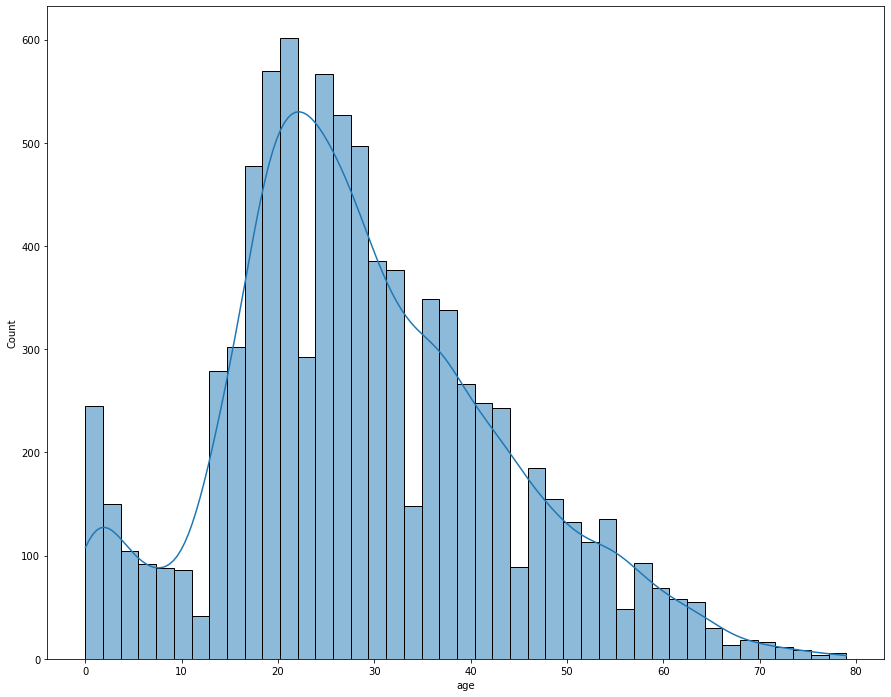

In [305]:
plt.figure(figsize=(15, 12))
sns.histplot(
    x='age',
    data=df,
    kde=True,
)


From checking the distribution of ages in the dataset, <br> it can be observed that a majority of people on the spaceship were between the ages ~18 and 30

In [306]:
mean, median, mode = mct(df, 'age')


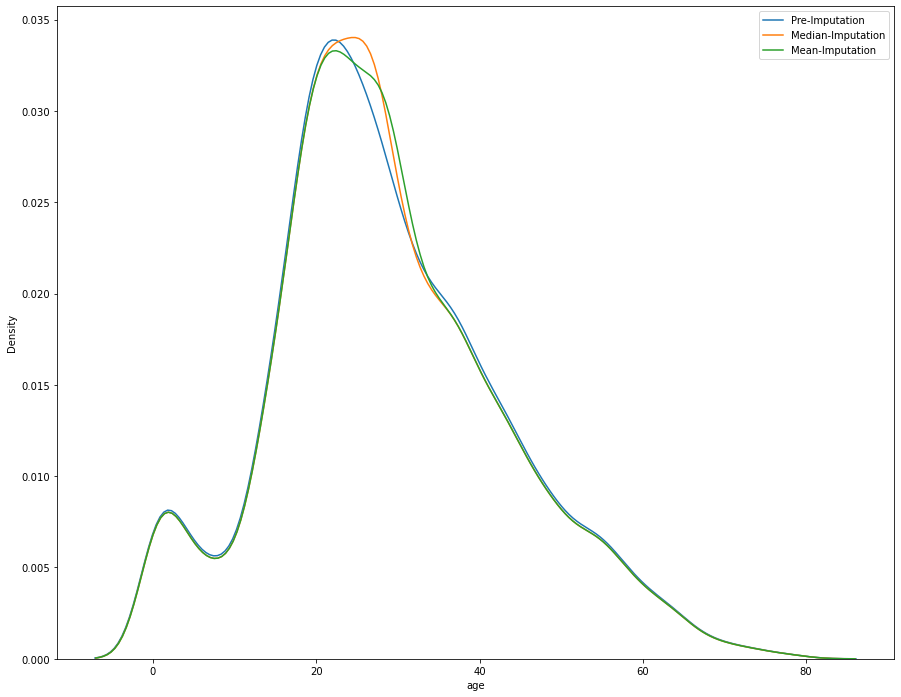

In [307]:
plt.figure(figsize=(15, 12))
sns.kdeplot(
    x='age',
    data=df,
    label="Pre-Imputation"
)

sns.kdeplot(
    x=df['age'].fillna(median),
    data=df,
    label="Median-Imputation"
)
plt.legend()
sns.kdeplot(
    x=df['age'].fillna(mean),
    data=df,
    label="Mean-Imputation"
)
plt.legend()


Since the imputing the missing values using the median does not affect the data distribution, it is used to impute the missing values.

In [308]:
df['age'].fillna(median, inplace=True)


In [309]:
df.select_dtypes(include=np.number).isnull().sum()


age               0
roomservice     181
foodcourt       183
shoppingmall    208
spa             183
vrdeck          188
dtype: int64

#### **Room Service**


<AxesSubplot:xlabel='roomservice', ylabel='Density'>

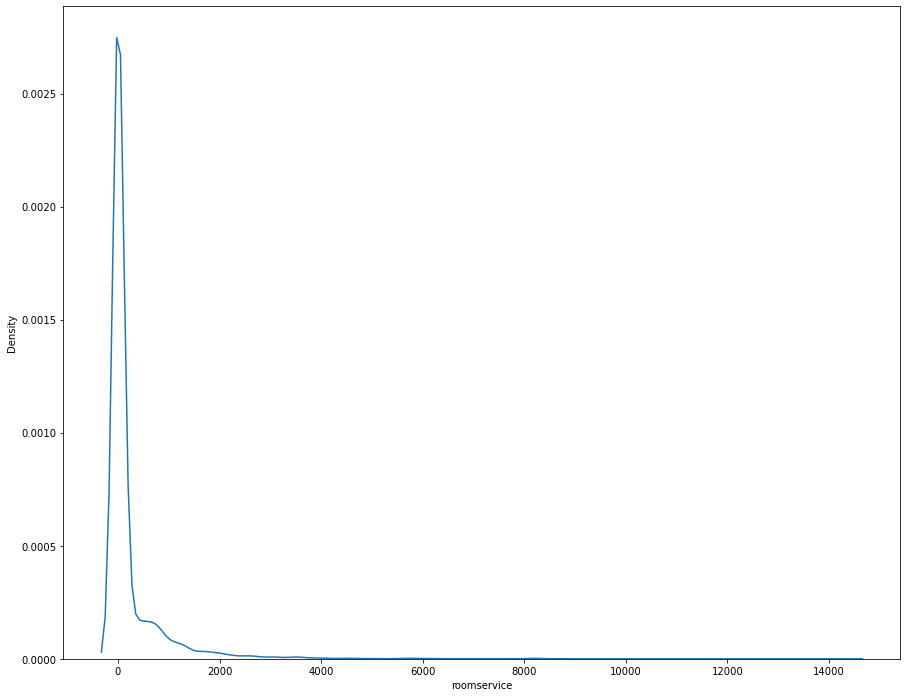

In [310]:
plt.figure(figsize=(15, 12))
sns.kdeplot(
    x='roomservice',
    data=df,
    # kde = True,
)


Here it can also be observed that a lot of people did not pay for room service and very few people paid above 2000

In [311]:
df.roomservice.isnull().sum()


181

In [312]:
mean, median, mode = mct(df, "roomservice")


In [313]:
mean, median, mode


(224.687617481203,
 0.0,
 0    0.0
 Name: roomservice, dtype: float64)

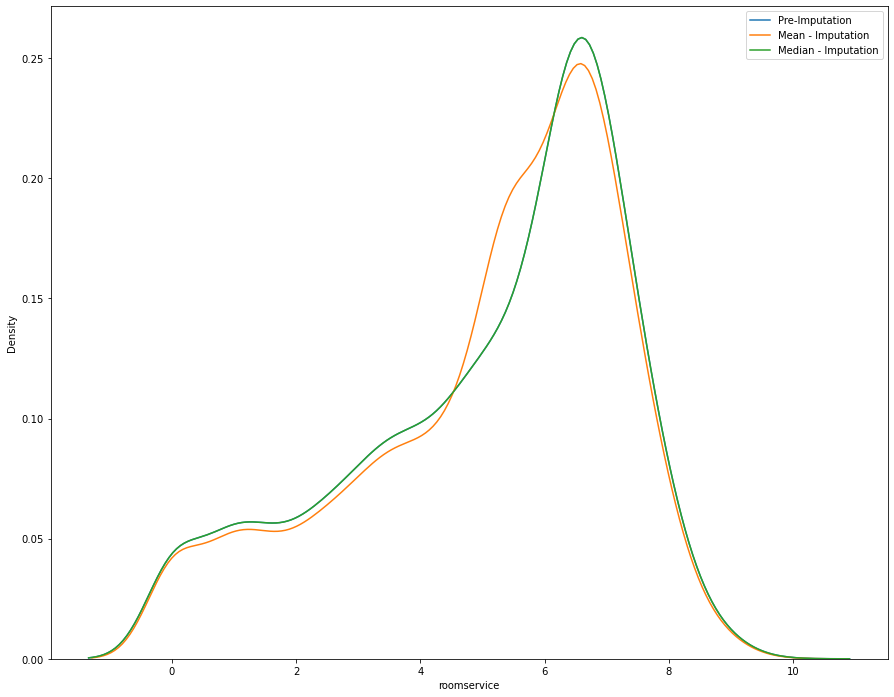

In [314]:
plt.figure(figsize=(15, 12))
sns.kdeplot(
    x=np.log(df['roomservice']),
    data=df,
    label='Pre-Imputation'
)
sns.kdeplot(
    x=np.log(df['roomservice'].fillna(mean)),
    data=df,
    label="Mean - Imputation"
)
sns.kdeplot(
    x=np.log(df['roomservice'].fillna(median)),
    data=df,
    label="Median - Imputation"
)
plt.legend()


In [315]:
df.roomservice.fillna(median, inplace=True)


Also, since the median does not have a significant impact on the distribution, it is used to impute the missing values.

#### **Food Court**


<AxesSubplot:xlabel='foodcourt', ylabel='Density'>

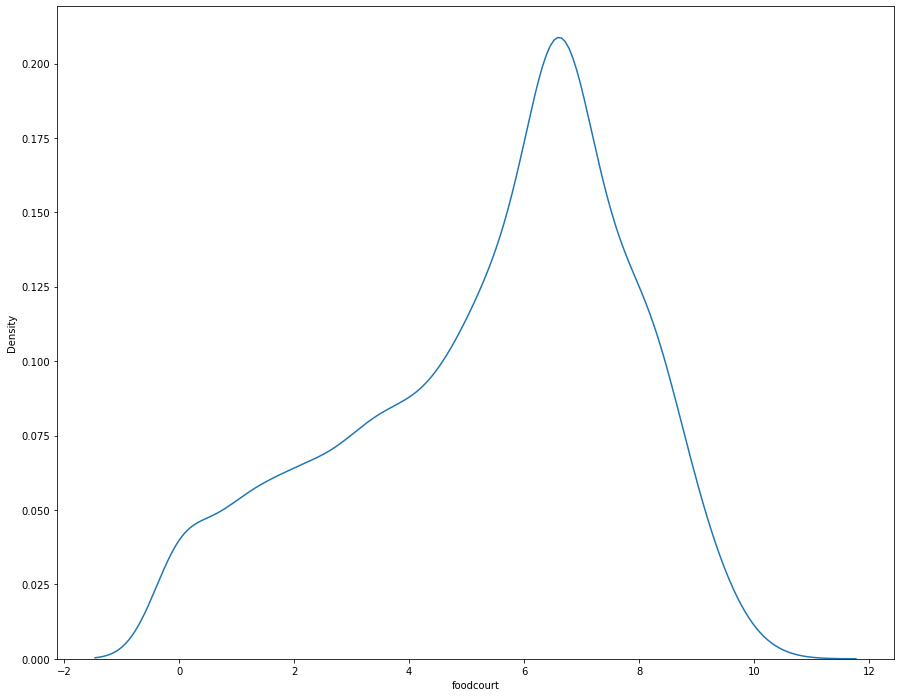

In [316]:
plt.figure(figsize=(15, 12))
sns.kdeplot(
    x=np.log(df['foodcourt']),
    data=df,
    # kde = True,
)


In [317]:
mean, median, mode = mct(df, "foodcourt")


In [318]:
mean, median, mode


(458.07720329024676,
 0.0,
 0    0.0
 Name: foodcourt, dtype: float64)

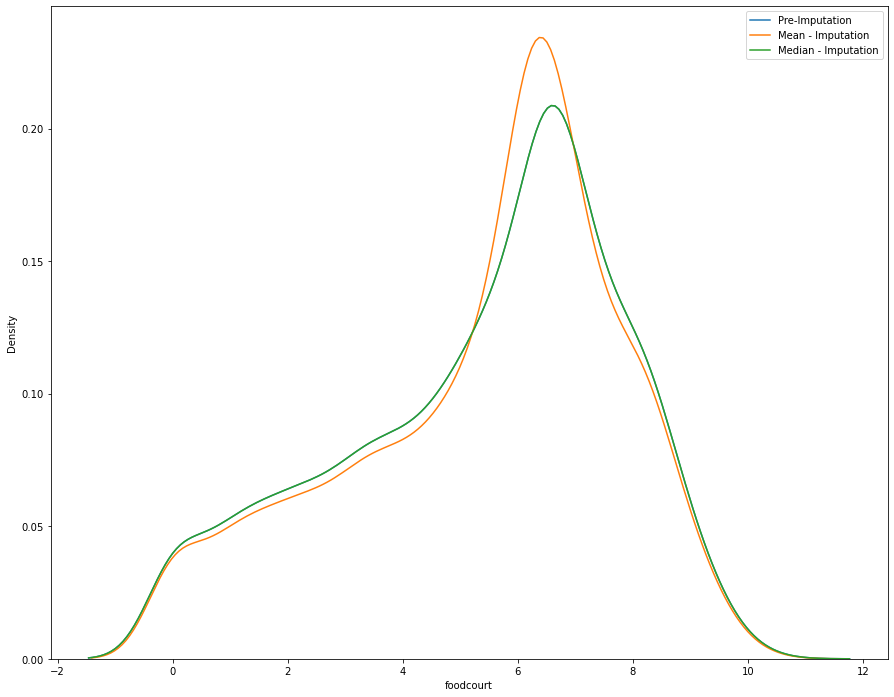

In [319]:
plt.figure(figsize=(15, 12))
sns.kdeplot(
    x=np.log(df['foodcourt']),
    data=df,
    label='Pre-Imputation'
)
sns.kdeplot(
    x=np.log(df['foodcourt'].fillna(mean)),
    data=df,
    label="Mean - Imputation"
)
sns.kdeplot(
    x=np.log(df['foodcourt'].fillna(median)),
    data=df,
    label="Median - Imputation"
)
plt.legend()


In [320]:
df.roomservice.fillna(median, inplace=True)


#### Shopping Mall


shoppingmall
Mean -   458.07720329024676
Median - 0.0
Mode -   0    0.0
Name: foodcourt, dtype: float64




,passengerid,homeplanet,cryosleep,cabin,destination,age,vip,roomservice,foodcourt,shoppingmall,spa,vrdeck,name,transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


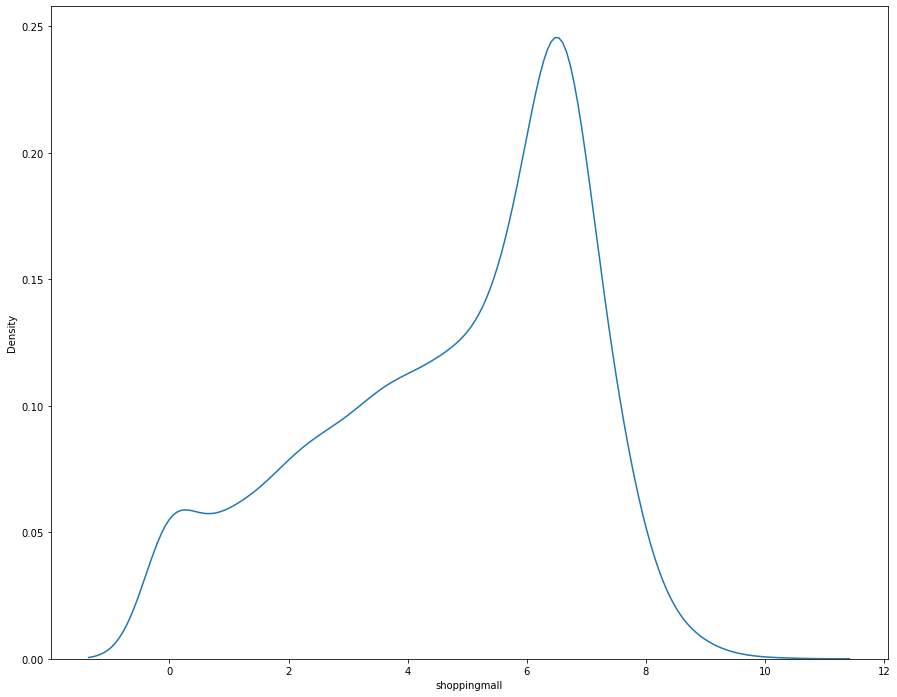

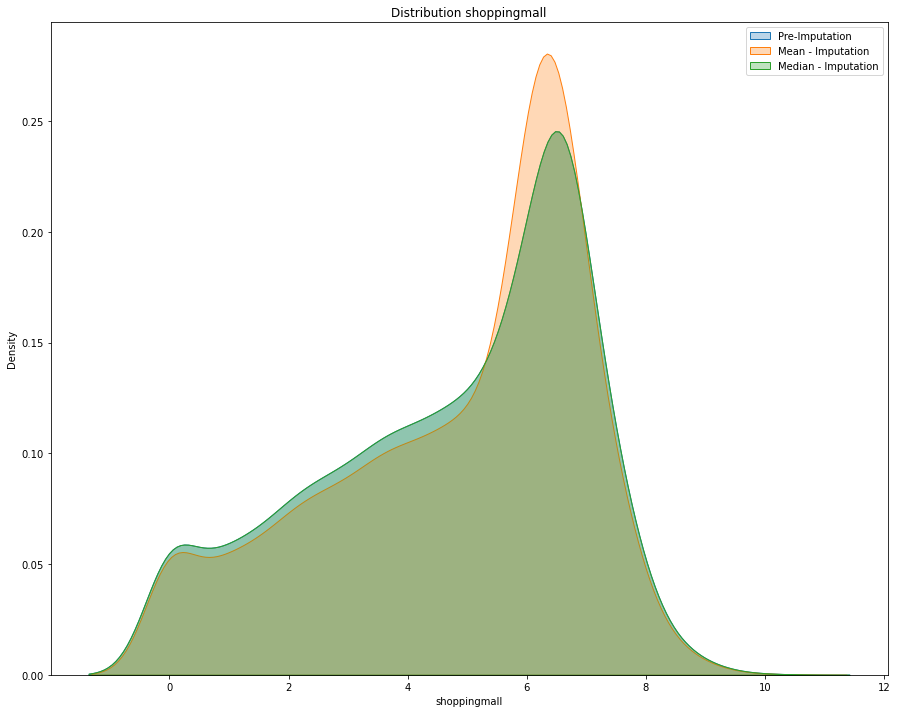

In [321]:
services_preprocessing(df, "shoppingmall")


#### **Spa and VR-Deck**


spa
Mean -   458.07720329024676
Median - 0.0
Mode -   0    0.0
Name: foodcourt, dtype: float64




,passengerid,homeplanet,cryosleep,cabin,destination,age,vip,roomservice,foodcourt,shoppingmall,spa,vrdeck,name,transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


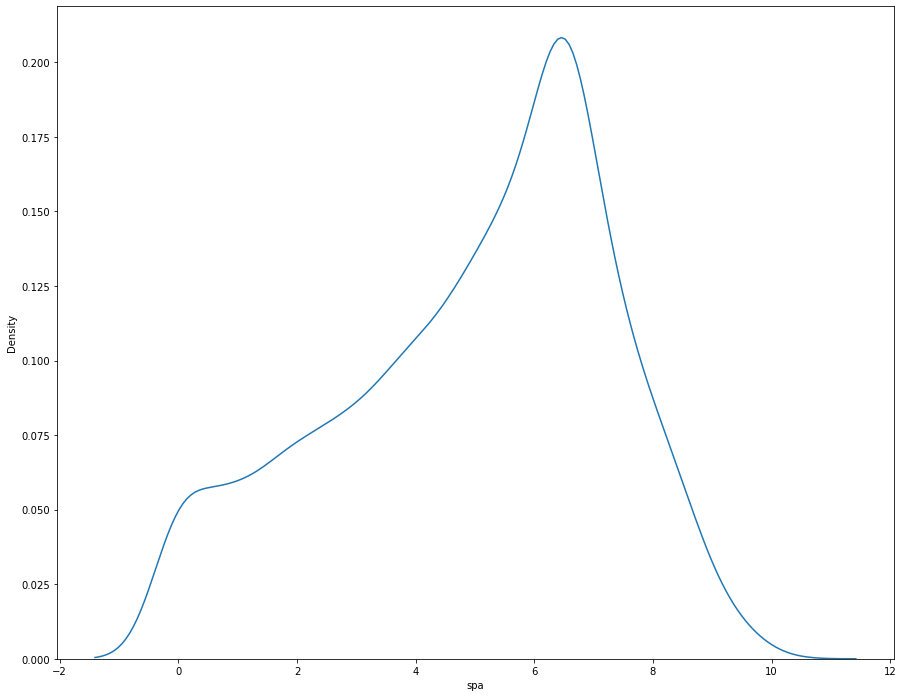

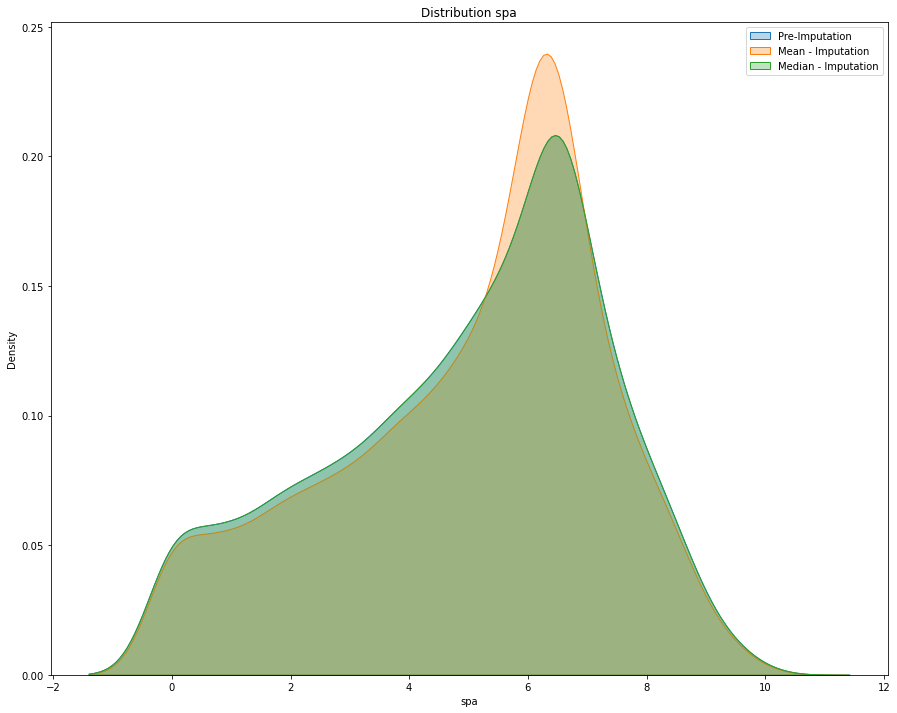

In [322]:
services_preprocessing(df, "spa")


vrdeck
Mean -   458.07720329024676
Median - 0.0
Mode -   0    0.0
Name: foodcourt, dtype: float64




,passengerid,homeplanet,cryosleep,cabin,destination,age,vip,roomservice,foodcourt,shoppingmall,spa,vrdeck,name,transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


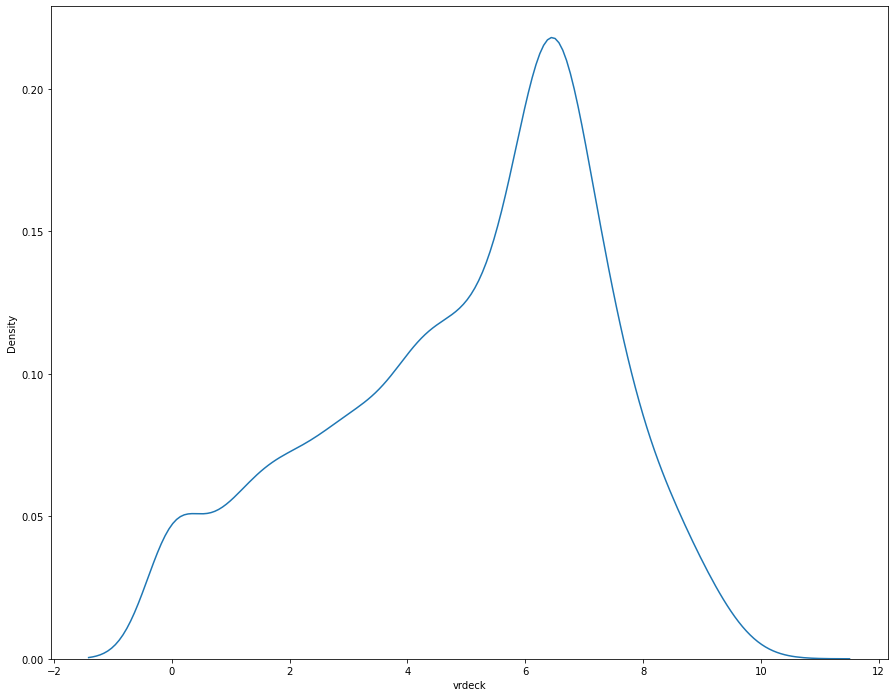

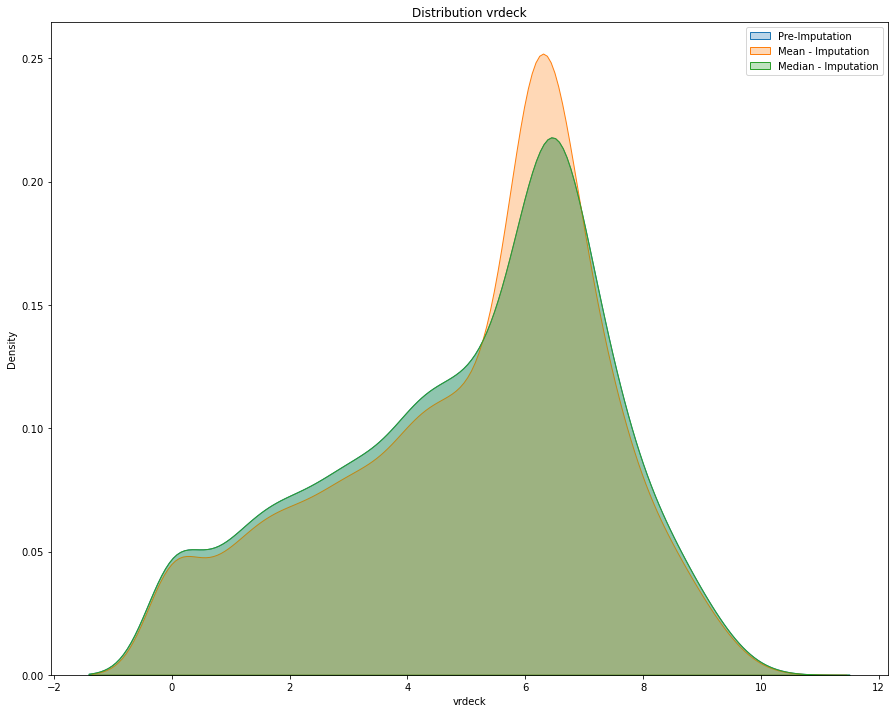

In [323]:
services_preprocessing(df, "vrdeck")


#### **Home Planet**


In [324]:
df.isnull().sum()


passengerid       0
homeplanet      201
cryosleep       217
cabin           199
destination     182
age               0
vip             203
roomservice       0
foodcourt       183
shoppingmall      0
spa               0
vrdeck            0
name            200
transported       0
dtype: int64

In [325]:
df['homeplanet'].fillna(df["homeplanet"].mode()[0], inplace=True)


#### **Destination**


In [326]:
df['destination'].fillna(df["destination"].mode()[0], inplace=True)


#### **Name**


Since names are unique


In [327]:
copy_df = df.copy()


In [328]:
copy_df.dropna(axis=0, inplace=True)


In [329]:
copy_df.reset_index(inplace=True)


**Feature Engineering**


In [330]:
df['name']


0         Maham Ofracculy
1            Juanna Vines
2           Altark Susent
3            Solam Susent
4       Willy Santantines
              ...        
8688    Gravior Noxnuther
8689      Kurta Mondalley
8690         Fayey Connon
8691     Celeon Hontichre
8692     Propsh Hontichre
Name: name, Length: 8693, dtype: object

Doing a check on a copy df to see if there are groups on the spaceship based on family or similar names.

However, since there are a lot of unique names in the dataset, it was dropped.

In [331]:
first = []
last = []

for i in range(len(copy_df)):
    first.append(copy_df['name'].str.split(" ")[i][0])
    last.append(copy_df['name'].str.split(" ")[i][1])


In [332]:
copy_df['firstname'], copy_df['lastname'] = first, last


In [333]:
copy_df


,index,passengerid,homeplanet,cryosleep,cabin,destination,age,vip,roomservice,foodcourt,shoppingmall,spa,vrdeck,name,transported,firstname,lastname
0,0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,Maham,Ofracculy
1,1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,Juanna,Vines
2,2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,Altark,Susent
3,3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,Solam,Susent
4,4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,Willy,Santantines
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7736,8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False,Gravior,Noxnuther
7737,8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False,Kurta,Mondalley
7738,8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True,Fayey,Connon
7739,8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False,Celeon,Hontichre


In [334]:
copy_df['lastname'].value_counts()


Casonston     17
Oneiles       15
Litthews      14
Cartez        13
Domington     13
              ..
Freptic        1
Comessic       1
Ecate          1
Icake          1
Sionerorly     1
Name: lastname, Length: 2180, dtype: int64

**Dropping the column**


In [335]:
df = df.drop('name', axis=1)

df.head()


,passengerid,homeplanet,cryosleep,cabin,destination,age,vip,roomservice,foodcourt,shoppingmall,spa,vrdeck,transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True


#### **Passengerid**


PassengerId - A unique Id for each passenger. <br> Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.


In [336]:
df.isnull().sum()


passengerid       0
homeplanet        0
cryosleep       217
cabin           199
destination       0
age               0
vip             203
roomservice       0
foodcourt       183
shoppingmall      0
spa               0
vrdeck            0
transported       0
dtype: int64

In [337]:
copy_df


,index,passengerid,homeplanet,cryosleep,cabin,destination,age,vip,roomservice,foodcourt,shoppingmall,spa,vrdeck,name,transported,firstname,lastname
0,0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,Maham,Ofracculy
1,1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,Juanna,Vines
2,2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,Altark,Susent
3,3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,Solam,Susent
4,4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,Willy,Santantines
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7736,8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False,Gravior,Noxnuther
7737,8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False,Kurta,Mondalley
7738,8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True,Fayey,Connon
7739,8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False,Celeon,Hontichre


Also tried to look for patterns based on family, drawing from the data description that passengers in the same group are most likely members of a family.

However, on checking the correlation, it was found that groups had little to do with being transported.

In [338]:
group = []
for i in range(len(copy_df)):
    group.append(copy_df['passengerid'].str.split('_')[i][0])

copy_df['group'] = group


In [339]:
copy_df.groupby('group')['transported'].value_counts(normalize=True)


group  transported
0001   False          1.0
0002   True           1.0
0003   False          1.0
0004   True           1.0
0005   True           1.0
                     ... 
9276   False          1.0
9278   False          1.0
9279   True           1.0
9280   False          0.5
       True           0.5
Name: transported, Length: 6391, dtype: float64

In [340]:
df.drop('passengerid', axis=1, inplace=True)


In [341]:
df.head()


,homeplanet,cryosleep,cabin,destination,age,vip,roomservice,foodcourt,shoppingmall,spa,vrdeck,transported
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False
4,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True


#### **Cabin**


Cabin - The cabin number where the passenger is staying. 
        Takes the form deck/num/side, where side can be either P for Port or S for Starboard.

Extracting the deck, num, and side from the cabin

In [342]:
deck = []
num = []
side = []

for i in range(len(copy_df)):
    deck.append(copy_df['cabin'].str.split('/')[i][0])
    num.append(copy_df['cabin'].str.split('/')[i][1])
    side.append(copy_df['cabin'].str.split('/')[i][2])

copy_df['deck'], copy_df['side'], copy_df['num'] = deck, side, num


**Checking the percentage of Transported per Deck**

In [343]:
copy_df.groupby('deck')['transported'].value_counts(normalize=True)


deck  transported
A     False          0.516949
      True           0.483051
B     True           0.734722
      False          0.265278
C     True           0.675595
      False          0.324405
D     False          0.569161
      True           0.430839
E     False          0.641089
      True           0.358911
F     False          0.564771
      True           0.435229
G     True           0.519536
      False          0.480464
T     False          0.666667
      True           0.333333
Name: transported, dtype: float64

In [344]:
copy_df.groupby('num')['transported'].value_counts(normalize=True)


num  transported
0    False          0.647059
     True           0.352941
1    True           0.666667
     False          0.333333
10   False          0.500000
                      ...   
997  False          1.000000
998  False          0.750000
     True           0.250000
999  True           0.800000
     False          0.200000
Name: transported, Length: 2942, dtype: float64

**Checking the percentage of Transported per Side**

In [345]:
copy_df.groupby('side')['transported'].value_counts(normalize=True)


side  transported
P     False          0.550483
      True           0.449517
S     True           0.554504
      False          0.445496
Name: transported, dtype: float64

In [346]:
df.cabin.fillna(df.cabin.mode()[0], inplace=True)


In [347]:
deck = []
num = []
side = []

for i in range(len(df)):
    deck.append(df['cabin'].str.split('/')[i][0])
    num.append(df['cabin'].str.split('/')[i][1])
    side.append(df['cabin'].str.split('/')[i][2])

df['deck'], df['side'], df['num'] = deck, side, num


In [348]:
df.isnull().sum()


homeplanet        0
cryosleep       217
cabin             0
destination       0
age               0
vip             203
roomservice       0
foodcourt       183
shoppingmall      0
spa               0
vrdeck            0
transported       0
deck              0
side              0
num               0
dtype: int64

#### **Cryosleep**


In [349]:
df.cryosleep.fillna(df.cryosleep.mode()[0], inplace=True)


#### **Vip**


In [172]:
df.cryosleep.fillna(df.cryosleep.mode()[0], inplace=True)


## **Visualisations**

#### **Travel Destination per Home Planet**

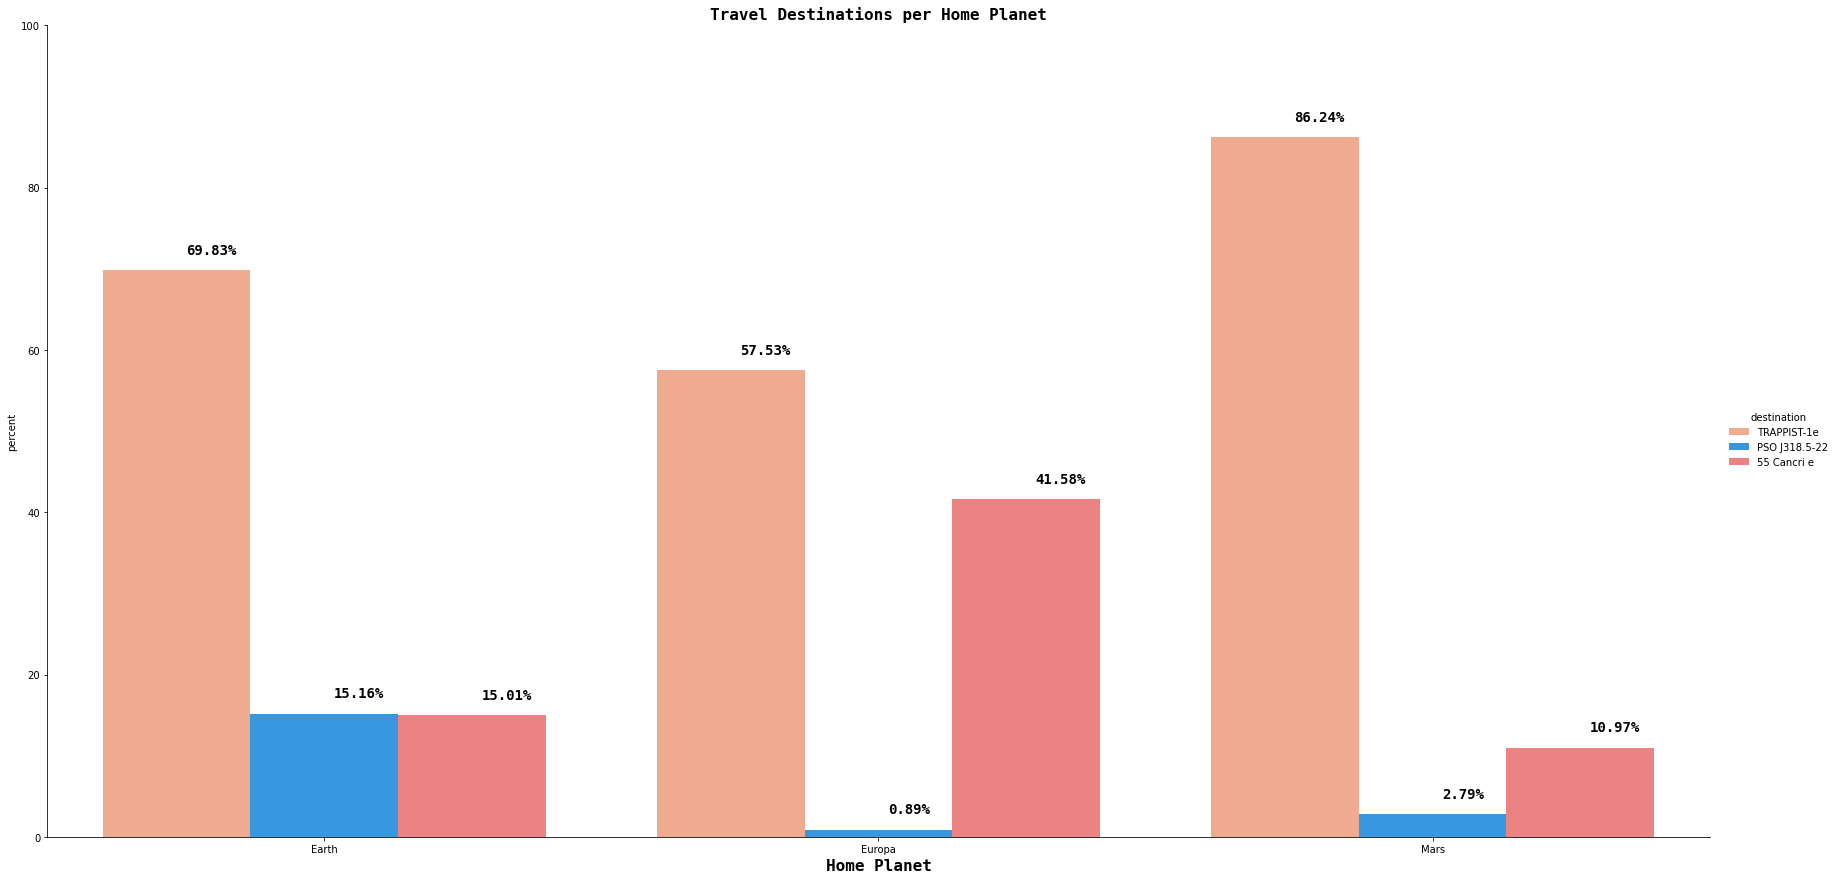

In [350]:
df_plot = df.groupby("homeplanet")['destination'].value_counts(normalize=True)
df_plot = df_plot.mul(100)
df_plot = df_plot.rename("percent").reset_index()
df_plot

g = sns.catplot(
  x = "homeplanet",
  y='percent',
  hue='destination',
  data=df_plot,
  kind='bar',
  height=12,
  aspect = 2,
  palette=["#FEA47F", "#1B9CFC", "#FD7272"]
)

g.ax.set_ylim(0, 100)
g.ax.set_title("Travel Destinations per Home Planet", fontdict=title_fontdict)
g.ax.set_xlabel("Home Planet", fontdict=title_fontdict)

add_pct(g)

It can be observed that a majority of passengers on the spaceship are headed to TRAPPIST-1e

#### **Number of People in Cryosleep based on Home Planet**

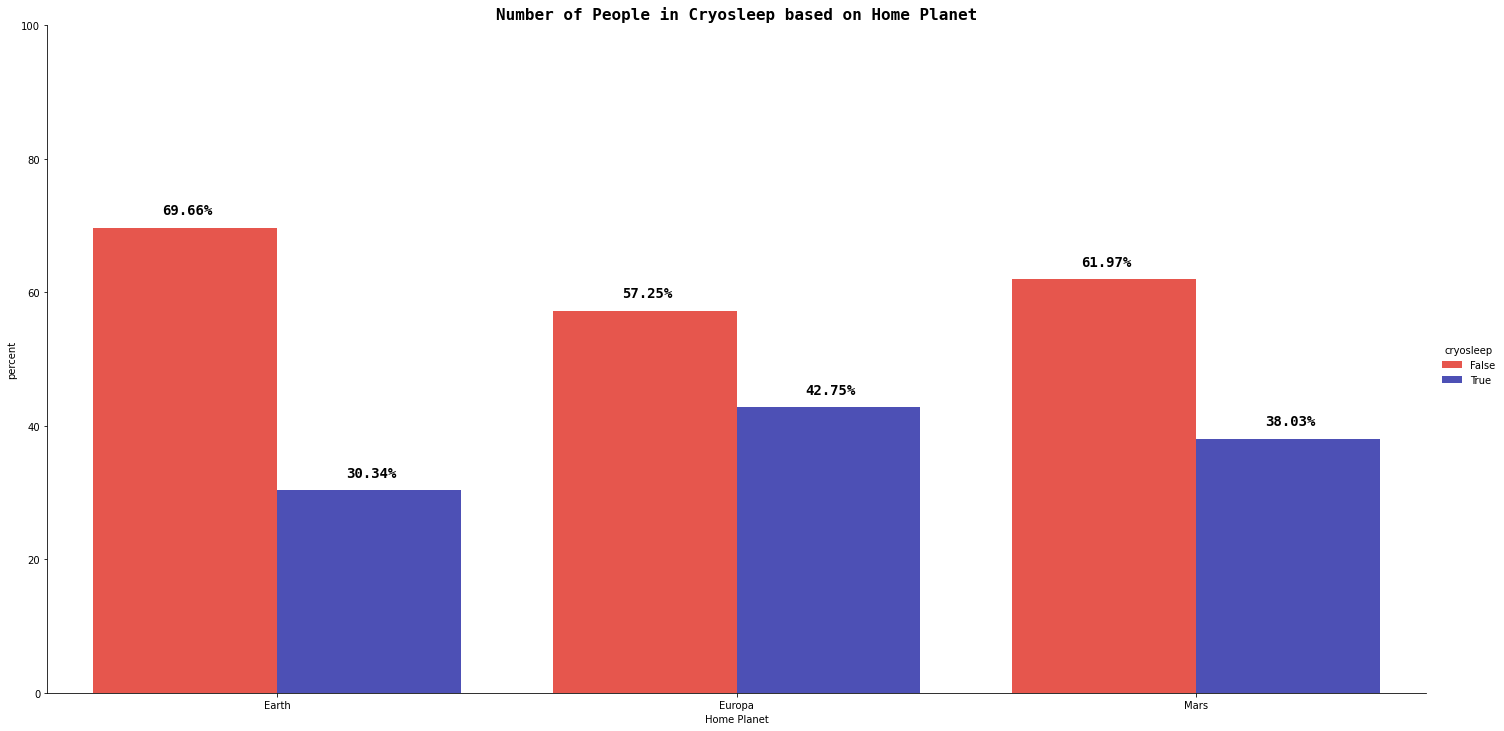

In [351]:
df_plot = df.groupby("homeplanet")['cryosleep'].value_counts(normalize=True)
df_plot = df_plot.mul(100)
df_plot = df_plot.rename("percent").reset_index()
df_plot


g = sns.catplot(
  x = 'homeplanet',
  y = "percent",
  hue = "cryosleep",
  data = df_plot,
  kind='bar',
  height = 10,
  aspect = 2,
  palette=["#ff3f34", "#3c40c6"]
)
g.ax.set_ylim(0, 100)
g.ax.set_title("Number of People in Cryosleep based on Home Planet", fontdict=title_fontdict)
g.ax.set_xlabel("Home Planet")

add_pct(g)

#### **Passenger Percentages Based on Destinations**

In [176]:
labels = df['destination'].value_counts().index.tolist()

values = df["destination"].value_counts().values.tolist()

([<matplotlib.patches.Wedge at 0x7f9efc84b250>,
 [Text(-0.6503849833453142, 150.88712985150931, 'TRAPPIST-1e'),
  Text(0.37196463107773453, 148.96479841903752, '55 Cancri e'),
  Text(1.0547985847504142, 149.68791035645424, 'PSO J318.5-22')],
 [Text(-0.35475544546108045, 150.48388900991415, '70.14%'),
  Text(0.20288979876967336, 149.43534459220228, '20.71%'),
  Text(0.575344682591135, 149.82976928533867, '9.16%')])

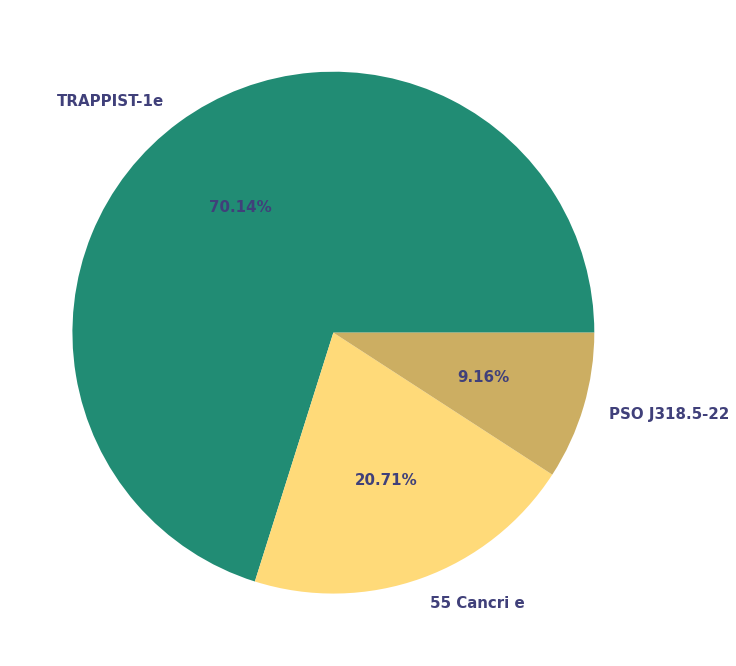

In [253]:

plt.figure(figsize=(15, 12))
plt.pie(
  x = values,
  labels=labels,
  autopct="%.2f%%",
  radius=1,
  center = (0, 150),
  textprops = {
    'color': '#40407a',
    'fontsize': 15,
    'fontweight': 'bold'
  },
  colors=["#218c74", "#ffda79", "#ccae62"]
)

We have 70.14% of people going to TRAPPIST-1e, 20.71% to 55 Cancri e, and 9.16% are headed to PSO j318.5-22

#### **Age Distribution Based on Home Planet**

Text(0.5, 0, 'Age')

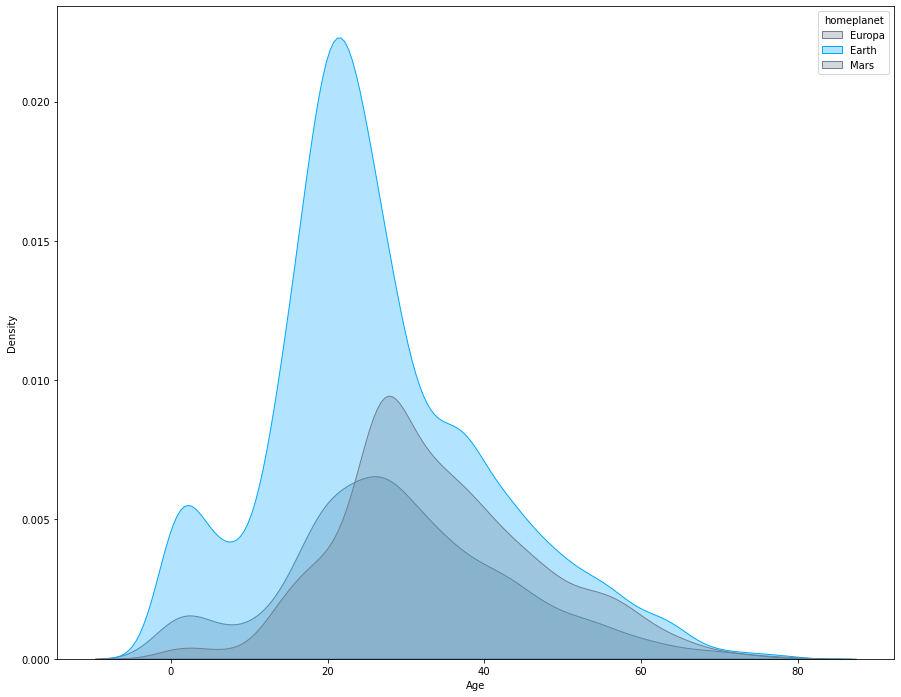

In [352]:
plt.figure(figsize=(15, 12))
sns.kdeplot(
  x = df["age"],
  hue = df["homeplanet"],
  palette = ['#718093', '#00a8ff', '#718093'],
  alpha = 0.3,
  shade=True
)

plt.xlabel("Age")

In the dataset we have more passengers from earth than from any other planet, with a majority of them being between the ages of ~18 and 40

#### **Transported population based on Home Planet**

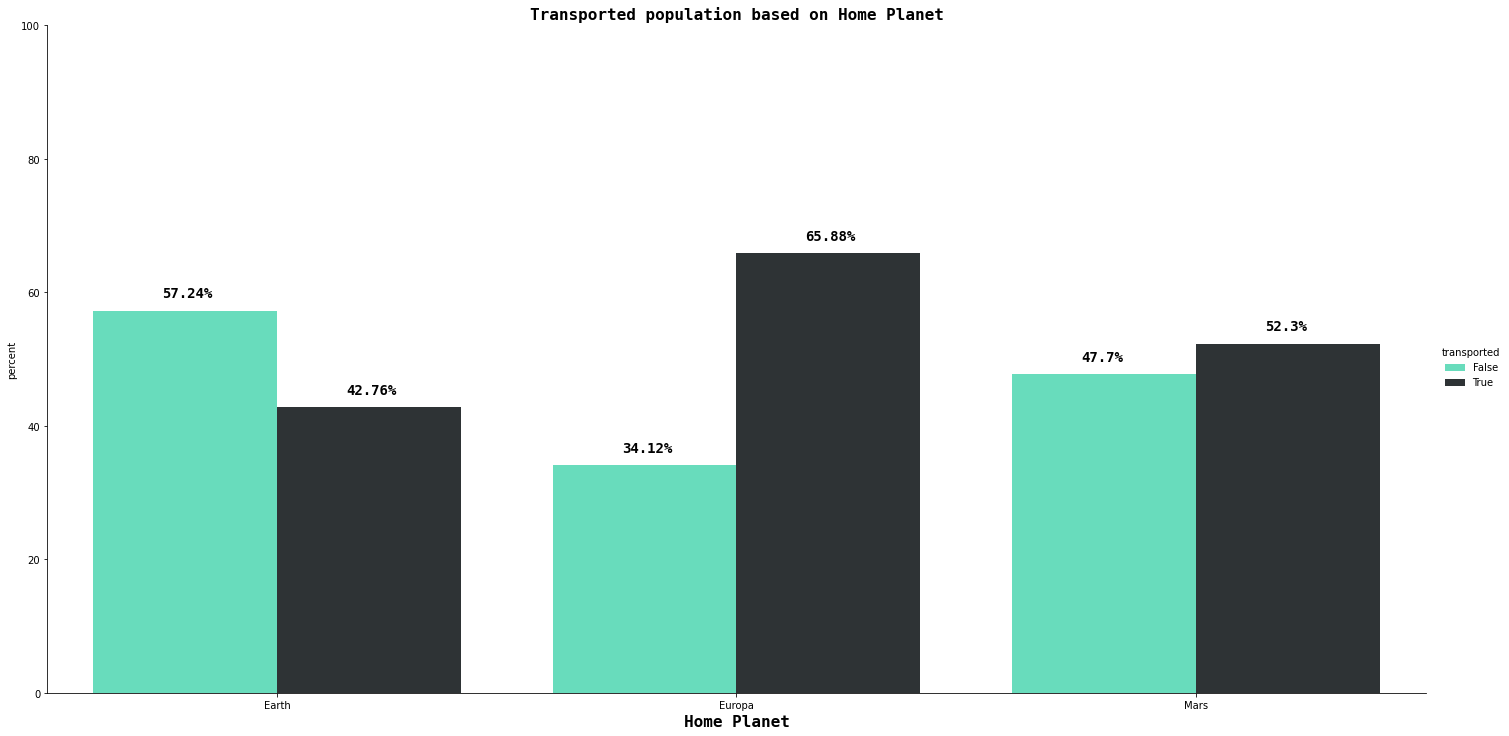

In [353]:
df_plot = df.groupby("homeplanet")['transported'].value_counts(normalize=True)
df_plot = df_plot.mul(100)
df_plot = df_plot.rename("percent").reset_index()
df_plot


g = sns.catplot(
  x = 'homeplanet',
  y = "percent",
  hue = "transported",
  data = df_plot,
  kind='bar',
  height = 10,
  aspect = 2,
  palette=["#55efc4", "#2d3436"]
)
g.ax.set_ylim(0, 100)
g.ax.set_xlabel("Home Planet", fontdict=title_fontdict)
g.ax.set_title("Transported population based on Home Planet", fontdict = title_fontdict)

add_pct(g)

#### **Percentage of VIP passengers per Home Planet**

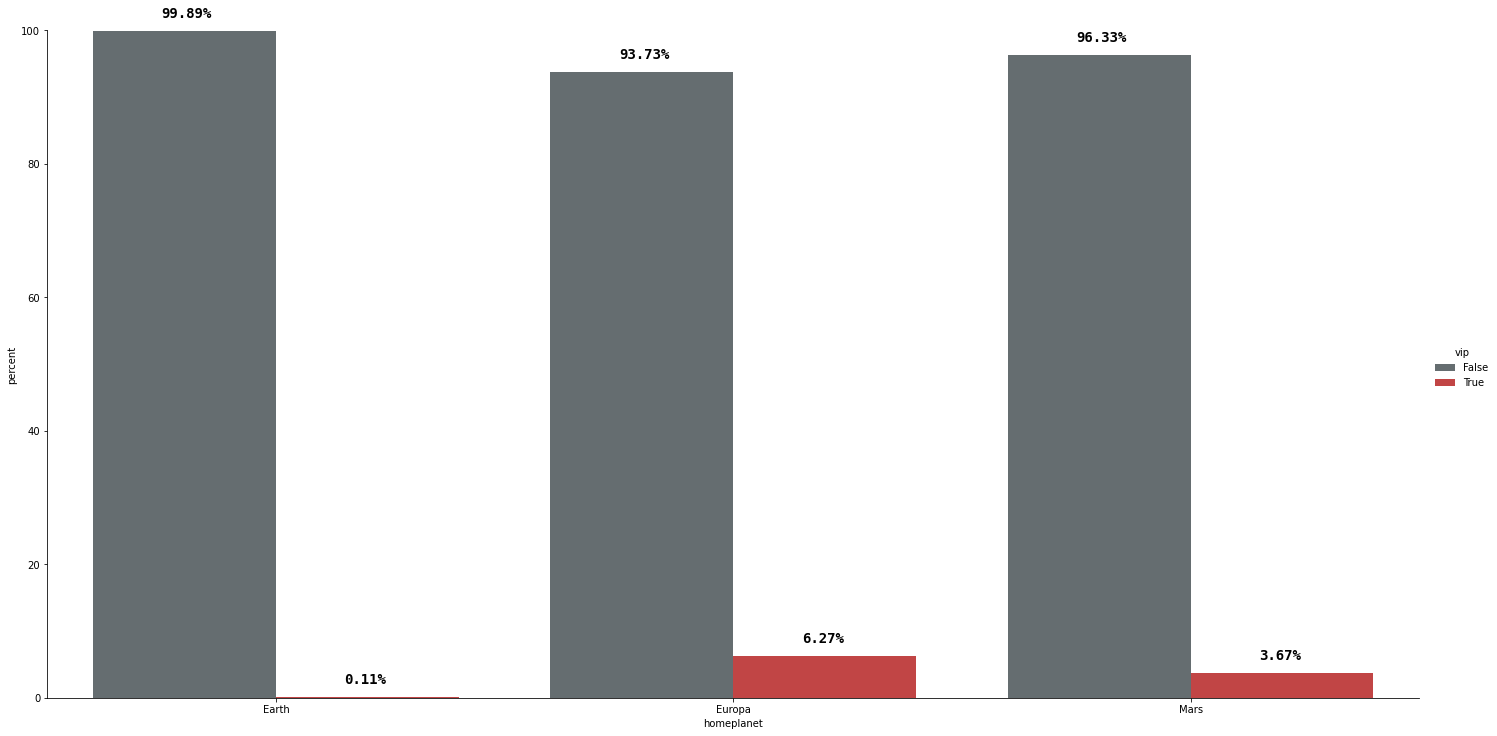

In [354]:
df_plot = df.groupby("homeplanet")['vip'].value_counts(normalize=True)
df_plot = df_plot.mul(100)
df_plot = df_plot.rename("percent").reset_index()
df_plot


g = sns.catplot(
  x = 'homeplanet',
  y = "percent",
  hue = "vip",
  data = df_plot,
  kind='bar',
  height = 10,
  aspect = 2,
  palette=['#636e72', "#d63031"]
)
g.ax.set_ylim(0, 100)

add_pct(g)

#### **Cryosleep passenger population per side**

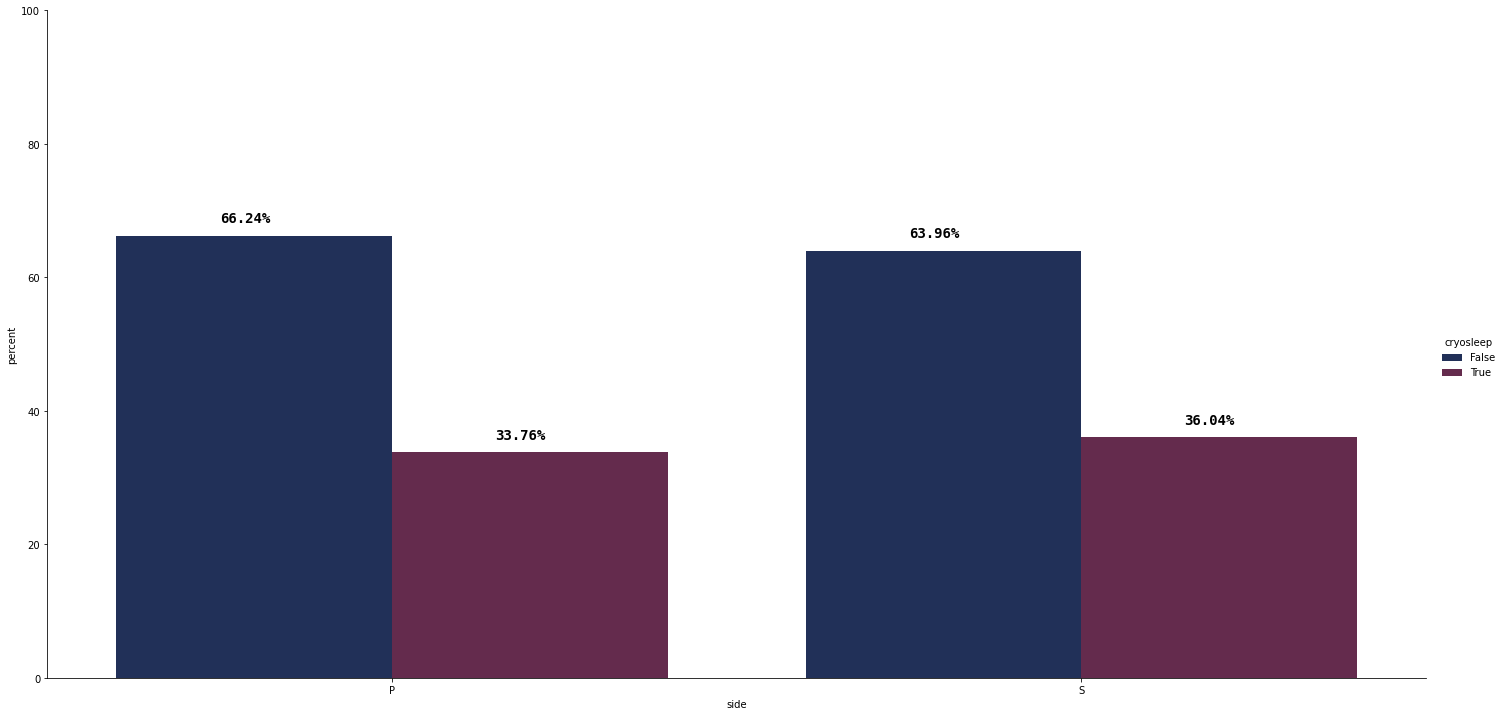

In [355]:
df_plot = df.groupby("side")['cryosleep'].value_counts(normalize=True)
df_plot = df_plot.mul(100)
df_plot = df_plot.rename("percent").reset_index()
df_plot


g = sns.catplot(
  x = 'side',
  y = "percent",
  hue = "cryosleep",
  data = df_plot,
  kind='bar',
  height = 10,
  aspect = 2,
  palette=["#182C61", "#6D214F"]
)

g.ax.set_ylim(0, 100)

add_pct(g)

#### **Cryosleep population per Deck**

posx and posy should be finite values
posx and posy should be finite values


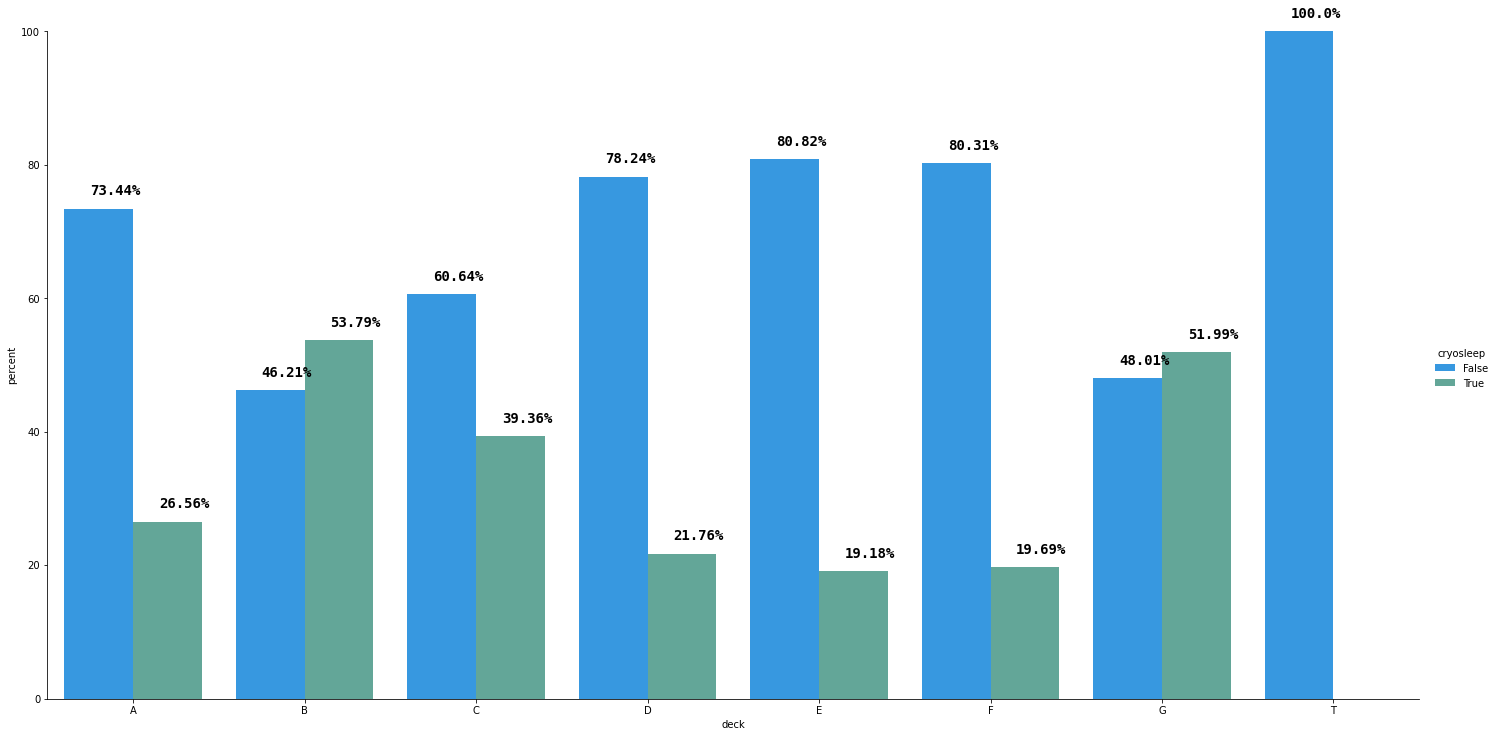

In [356]:
df_plot = df.groupby("deck")['cryosleep'].value_counts(normalize=True)
df_plot = df_plot.mul(100)
df_plot = df_plot.rename("percent").reset_index()
df_plot


g = sns.catplot(
  x = 'deck',
  y = "percent",
  hue = "cryosleep",
  data = df_plot,
  kind='bar',
  height = 10,
  aspect = 2,
  palette=['#1B9CFC', '#58B19F']
)
g.ax.set_ylim(0, 100)

add_pct(g)

#### **Vip population per deck**

posx and posy should be finite values
posx and posy should be finite values


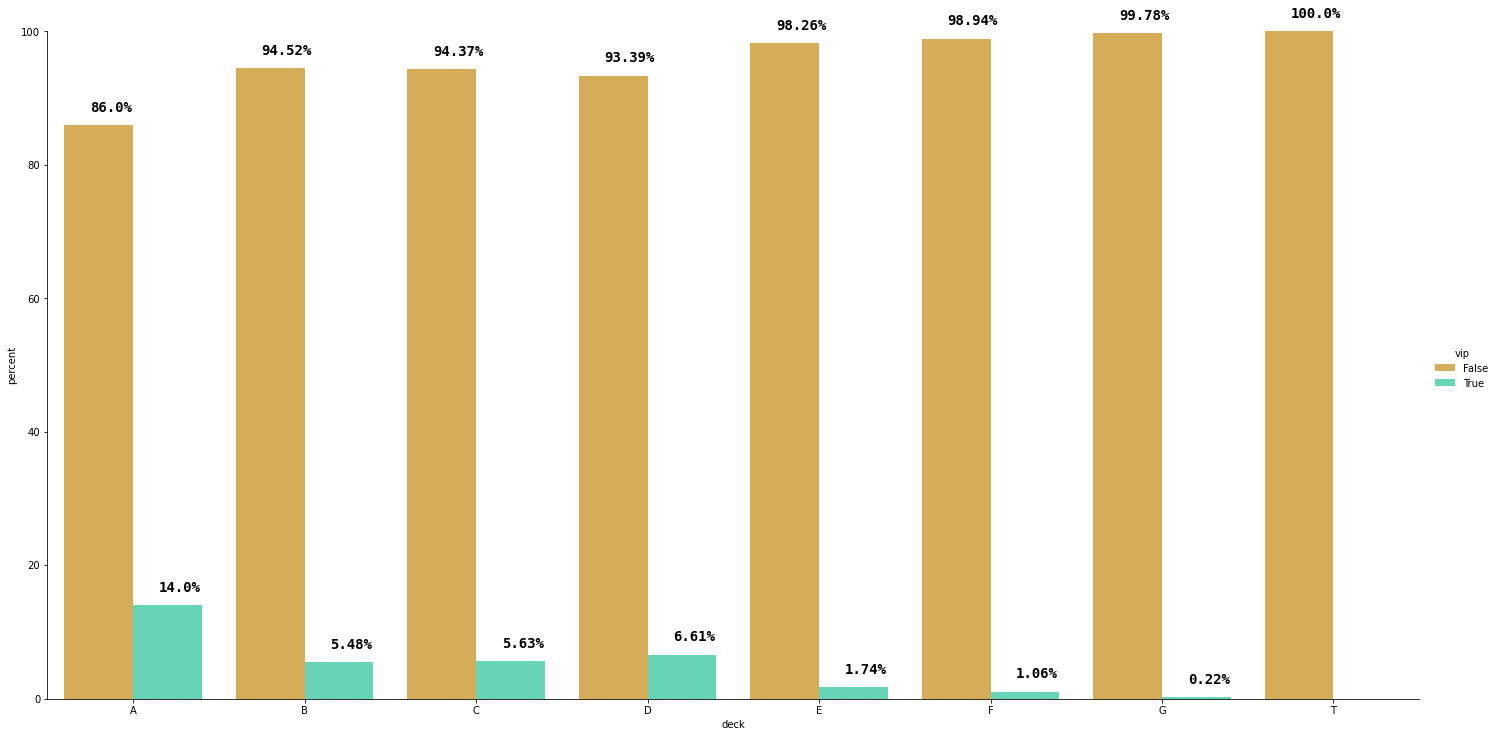

In [357]:
# plt.figure(figsize=(15, 12))

df_plot = df.groupby("deck")['vip'].value_counts(normalize=True)
df_plot = df_plot.mul(100)
df_plot = df_plot.rename("percent").reset_index()
df_plot


g = sns.catplot(
  x = 'deck',
  y = "percent",
  hue = "vip",
  data = df_plot,
  kind='bar',
  height = 10,
  aspect = 2,
  palette=['#EAB543', '#55E6C1']
)
g.ax.set_ylim(0, 100)

add_pct(g)

#### **Transported Population per Deck**

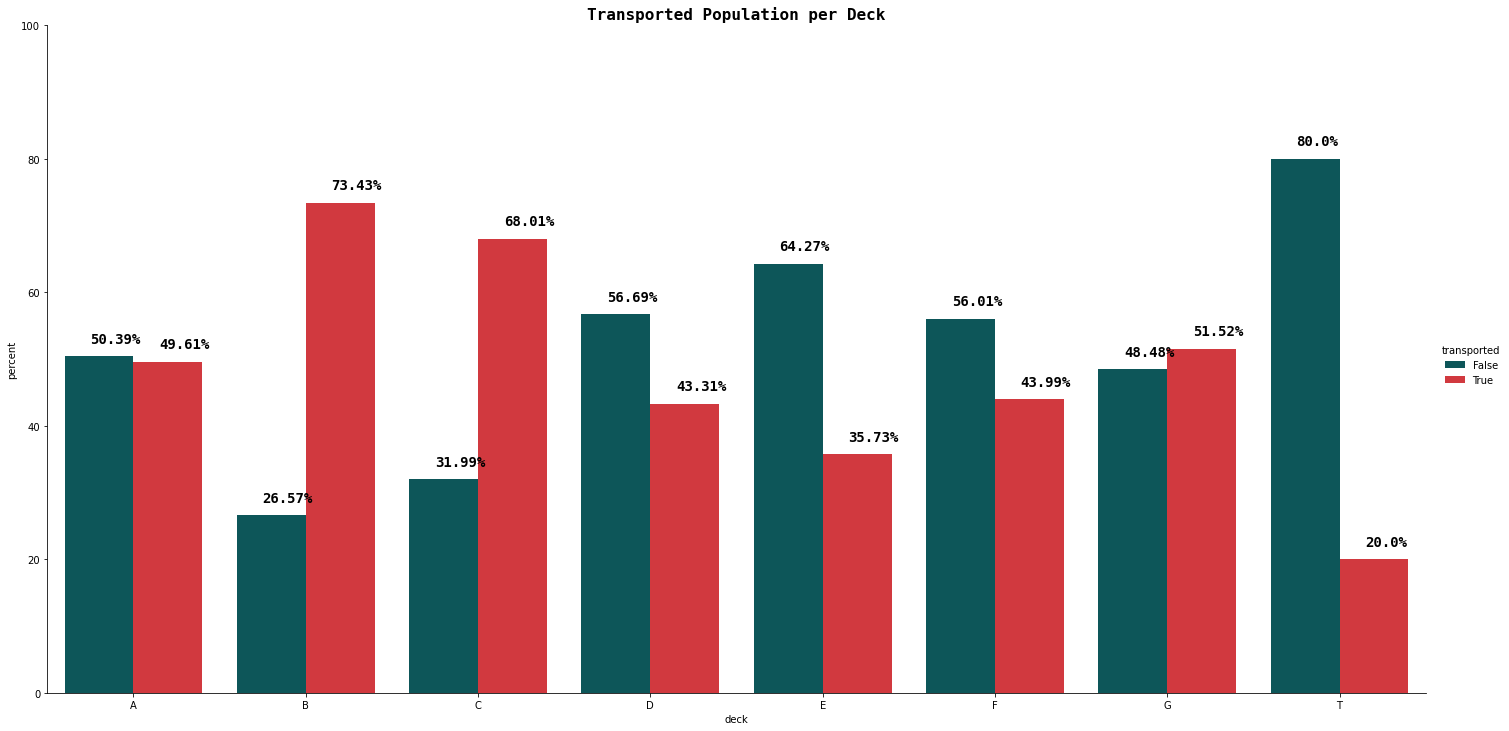

In [358]:
df_plot = df.groupby("deck")['transported'].value_counts(normalize=True)
df_plot = df_plot.mul(100)
df_plot = df_plot.rename("percent").reset_index()
df_plot


g = sns.catplot(
  x = 'deck',
  y = "percent",
  hue = "transported",
  data = df_plot,
  kind='bar',
  height = 10,
  aspect = 2,
  palette=["#006266", "#EA2027"]
)
g.ax.set_ylim(0, 100)
g.ax.set_title("Transported Population per Deck", fontdict=title_fontdict)

add_pct(g)

#### **Correlation**

In [359]:
corr = df.corr()

<AxesSubplot:>

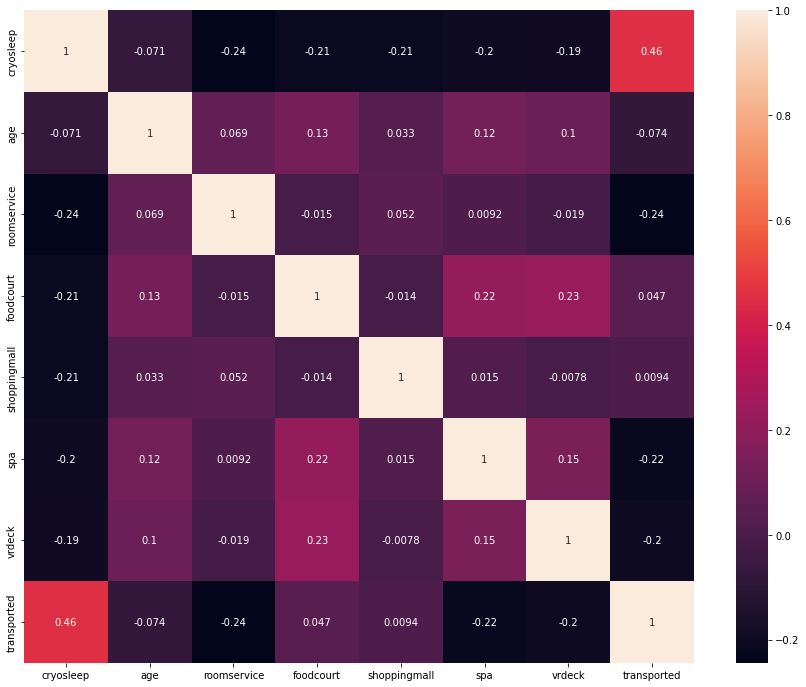

In [360]:
plt.figure(figsize=(15, 12))
sns.heatmap(corr, annot=True)

#### **Checking Relationships**

In [361]:
df[df.select_dtypes(include='bool').columns] = df.select_dtypes(include='bool').astype("float")

In [362]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   homeplanet    8693 non-null   object 
 1   cryosleep     8693 non-null   float64
 2   cabin         8693 non-null   object 
 3   destination   8693 non-null   object 
 4   age           8693 non-null   float64
 5   vip           8490 non-null   object 
 6   roomservice   8693 non-null   float64
 7   foodcourt     8510 non-null   float64
 8   shoppingmall  8693 non-null   float64
 9   spa           8693 non-null   float64
 10  vrdeck        8693 non-null   float64
 11  transported   8693 non-null   float64
 12  deck          8693 non-null   object 
 13  side          8693 non-null   object 
 14  num           8693 non-null   object 
dtypes: float64(8), object(7)
memory usage: 1018.8+ KB


## **Encoding**

In [364]:
df.drop('cabin', axis=1, inplace=True)


In [365]:
df.head()

,homeplanet,cryosleep,destination,age,vip,roomservice,foodcourt,shoppingmall,spa,vrdeck,transported,deck,side,num
0,Europa,0.0,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,0.0,B,P,0
1,Earth,0.0,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,1.0,F,S,0
2,Europa,0.0,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,0.0,A,S,0
3,Europa,0.0,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,0.0,A,S,0
4,Earth,0.0,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,1.0,F,S,1


Converting categorical columns into numerical columns

In [366]:
enc = LabelEncoder()
for col in df.select_dtypes(include=["object", 'bool']):
  df[col] = enc.fit_transform(df[col])

df

,homeplanet,cryosleep,destination,age,vip,roomservice,foodcourt,shoppingmall,spa,vrdeck,transported,deck,side,num
0,1,0.0,2,39.0,0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0
1,0,0.0,2,24.0,0,109.0,9.0,25.0,549.0,44.0,1.0,5,1,0
2,1,0.0,2,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0.0,0,1,0
3,1,0.0,2,33.0,0,0.0,1283.0,371.0,3329.0,193.0,0.0,0,1,0
4,0,0.0,2,16.0,0,303.0,70.0,151.0,565.0,2.0,1.0,5,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,1,0.0,0,41.0,1,0.0,6819.0,0.0,1643.0,74.0,0.0,0,0,1795
8689,0,1.0,1,18.0,0,0.0,0.0,0.0,0.0,0.0,0.0,6,1,548
8690,0,0.0,2,26.0,0,0.0,0.0,1872.0,1.0,0.0,1.0,6,1,551
8691,1,0.0,0,32.0,0,0.0,1049.0,0.0,353.0,3235.0,0.0,4,1,1385


Now there are only numerical columns in the data

## **Pre-Processing**

<AxesSubplot:>

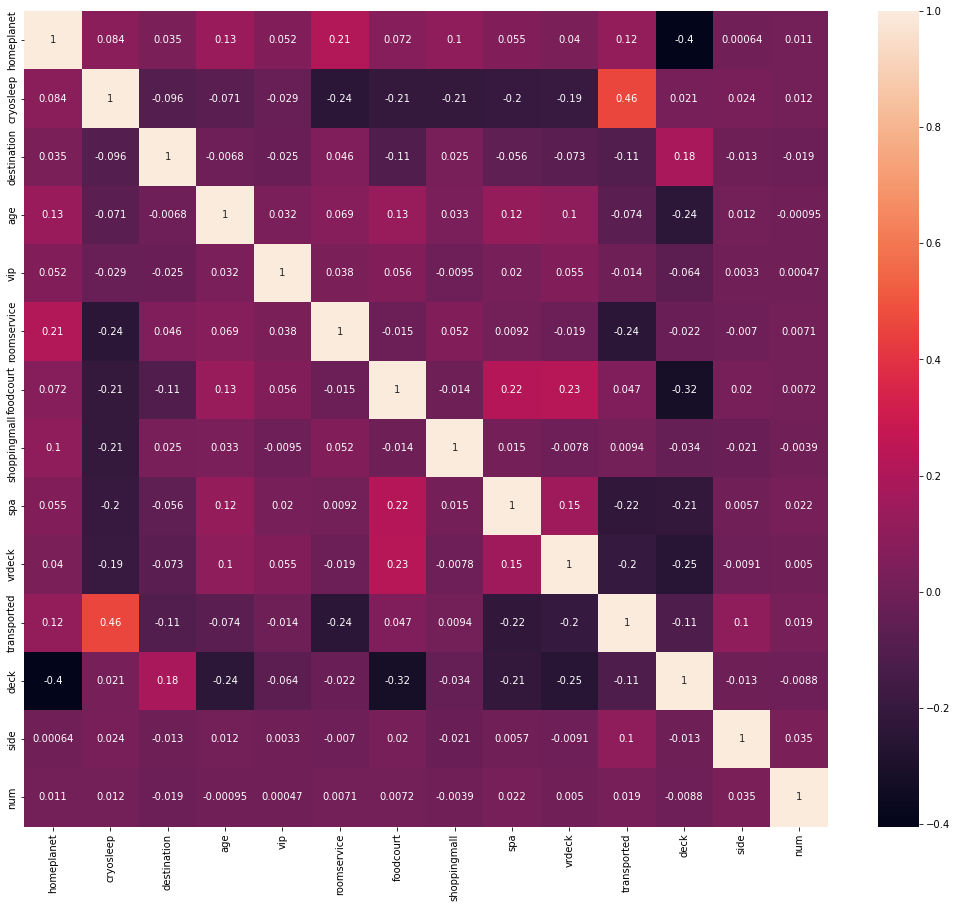

In [367]:
plt.figure(figsize=(18, 15))
sns.heatmap(df.corr(), annot=True)

Remove columns that have very low correlation with the target column (Transported)

In [368]:
model_df = df.drop(['age', 'vip', 'foodcourt', 'shoppingmall'], axis=1)

In [210]:
model_df

,homeplanet,cryosleep,destination,roomservice,spa,vrdeck,transported,deck,side,num
0,1,0.0,2,0.0,0.0,0.0,0.0,1,0,0
1,0,0.0,2,109.0,549.0,44.0,1.0,5,1,0
2,1,0.0,2,43.0,6715.0,49.0,0.0,0,1,0
3,1,0.0,2,0.0,3329.0,193.0,0.0,0,1,0
4,0,0.0,2,303.0,565.0,2.0,1.0,5,1,1
...,...,...,...,...,...,...,...,...,...,...
8688,1,0.0,0,0.0,1643.0,74.0,0.0,0,0,1795
8689,0,1.0,1,0.0,0.0,0.0,0.0,6,1,548
8690,0,0.0,2,0.0,1.0,0.0,1.0,6,1,551
8691,1,0.0,0,0.0,353.0,3235.0,0.0,4,1,1385


Defining the Features and Target sets

In [211]:
X = model_df.drop('transported', axis=1)
y = model_df.transported

Scaling the dataset

In [212]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [213]:
X_scaled

array([[ 0.44038529, -0.73277002,  0.62054498, ..., -1.88316058,
        -1.03286462, -1.89777212],
       [-0.81725903, -0.73277002,  0.62054498, ...,  0.36929925,
         0.9681811 , -1.89777212],
       [ 0.44038529, -0.73277002,  0.62054498, ..., -2.44627554,
         0.9681811 , -1.89777212],
       ...,
       [-0.81725903, -0.73277002,  0.62054498, ...,  0.93241421,
         0.9681811 , -0.80889416],
       [ 0.44038529, -0.73277002, -1.83368499, ..., -0.19381571,
         0.9681811 ,  0.83924416],
       [ 0.44038529, -0.73277002,  0.62054498, ..., -0.19381571,
         0.9681811 ,  0.83924416]])

Splitting the data into training and test sets

In [214]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=0)

## Modeling

#### LogisticRegression

In [215]:
log = LogisticRegression()
log.fit(X_train, y_train)

LogisticRegression()

In [217]:
accuracy_score(y_test, log.predict(X_test))

0.7791834387579069

#### **RandomForestClassifier**

In [371]:
rnd_frst = RandomForestClassifier(
  n_estimators=500,
  random_state=0
)

rnd_frst.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500, random_state=0)

In [374]:
accuracy_score(y_test, rnd_frst.predict(X_test))

0.7740080506037953

In [382]:
conf_mat = confusion_matrix(y_test, rnd_frst.predict(X_test))
conf_df = pd.DataFrame(conf_mat, columns=["Predicted False", "Predicted True"], index=["Actual False", "Actual False"])

<AxesSubplot:>

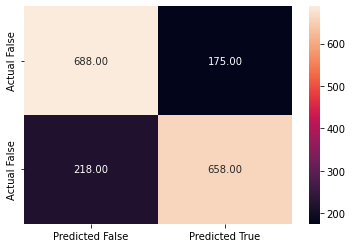

In [383]:
sns.heatmap(conf_df, annot=True, fmt=".2f")

## Test Set Preparer Function

In [385]:
def prepare(df):

  df.columns = df.columns.str.lower()

  cols = [
    'age', 'roomservice', 'foodcourt',
    'shoppingmall', 'spa', 'vrdeck'
    ]

  cat_cols = ['homeplanet', 'destination', 'cryosleep']

  for col in cols:
    df = services_preprocessing(df, col, False)

  df['homeplanet'].fillna(df["homeplanet"].mode()[0], inplace=True)
  df['destination'].fillna(df["destination"].mode()[0], inplace=True)
  df['cryosleep'].fillna(df['cryosleep'].mode()[0], inplace=True)


  df.drop('passengerid', axis=1, inplace=True)

  df.cabin.fillna(df.cabin.mode()[0], inplace=True)

  deck = []
  num = []
  side = []

  for i in range(len(df)):
      deck.append(df['cabin'].str.split('/')[i][0])
      num.append(df['cabin'].str.split('/')[i][1])
      side.append(df['cabin'].str.split('/')[i][2])

  df['deck'], df['side'], df['num'] = deck, side, num
  df.drop('cabin', axis=1, inplace=True)


  enc = LabelEncoder()
  for col in df.select_dtypes(include=["object", 'bool']):
    df[col] = enc.fit_transform(df[col])

  df.drop(['name', 'age', 'vip', 'foodcourt', 'shoppingmall'], axis=1, inplace=True)


  df = scaler.transform(df)

  return df

In [386]:
test = pd.read_csv("spaceship-titanic/test.csv")
test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


age
Mean -   439.4842963318149
Median - 0.0
Mode -   0    0.0
Name: foodcourt, dtype: float64


roomservice
Mean -   439.4842963318149
Median - 0.0
Mode -   0    0.0
Name: foodcourt, dtype: float64


foodcourt
Mean -   439.4842963318149
Median - 0.0
Mode -   0    0.0
Name: foodcourt, dtype: float64


shoppingmall
Mean -   428.59223754968434
Median - 0.0
Mode -   0    0.0
Name: foodcourt, dtype: float64


spa
Mean -   428.59223754968434
Median - 0.0
Mode -   0    0.0
Name: foodcourt, dtype: float64


vrdeck
Mean -   428.59223754968434
Median - 0.0
Mode -   0    0.0
Name: foodcourt, dtype: float64




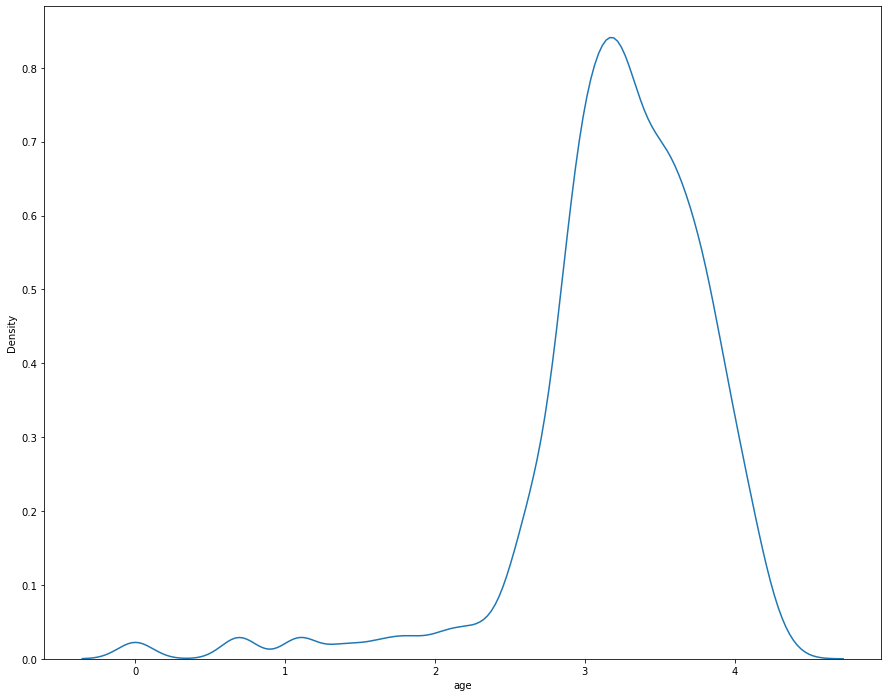

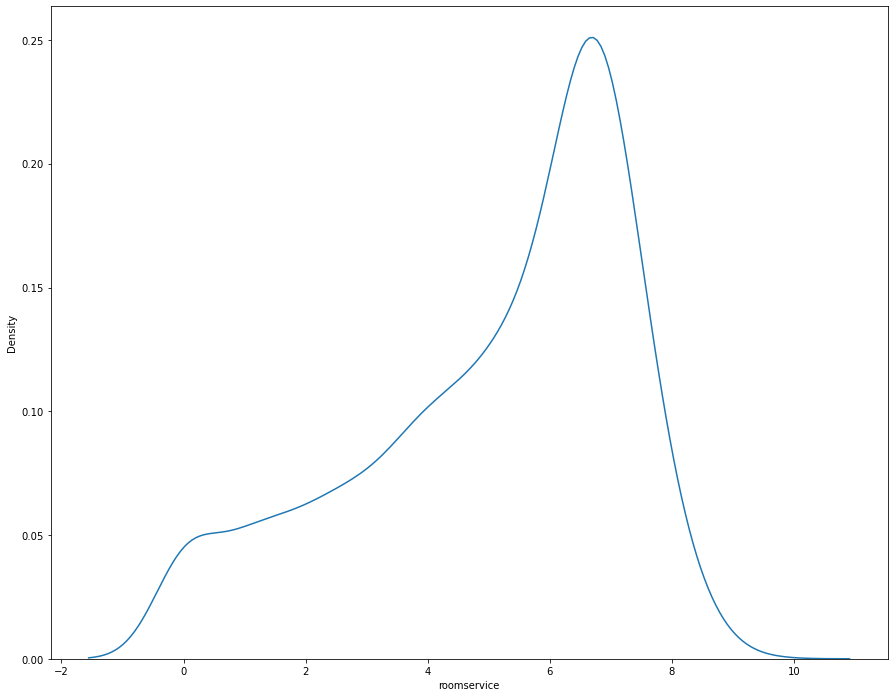

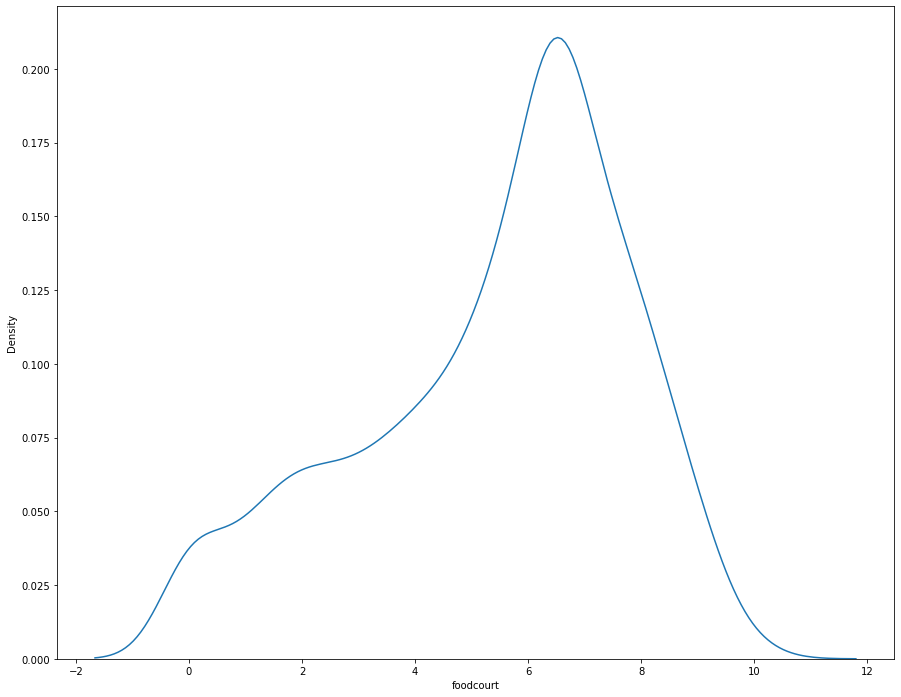

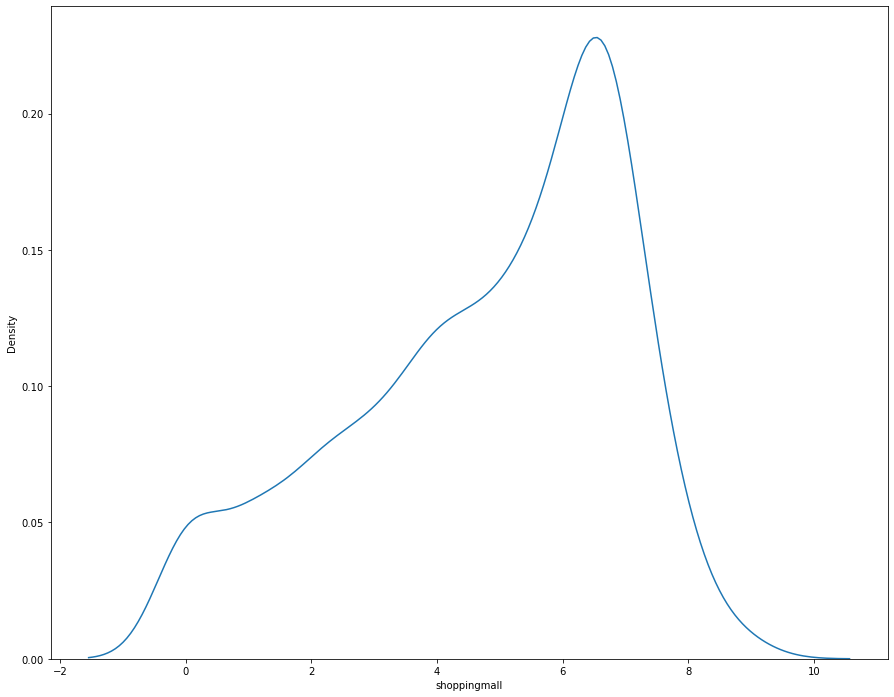

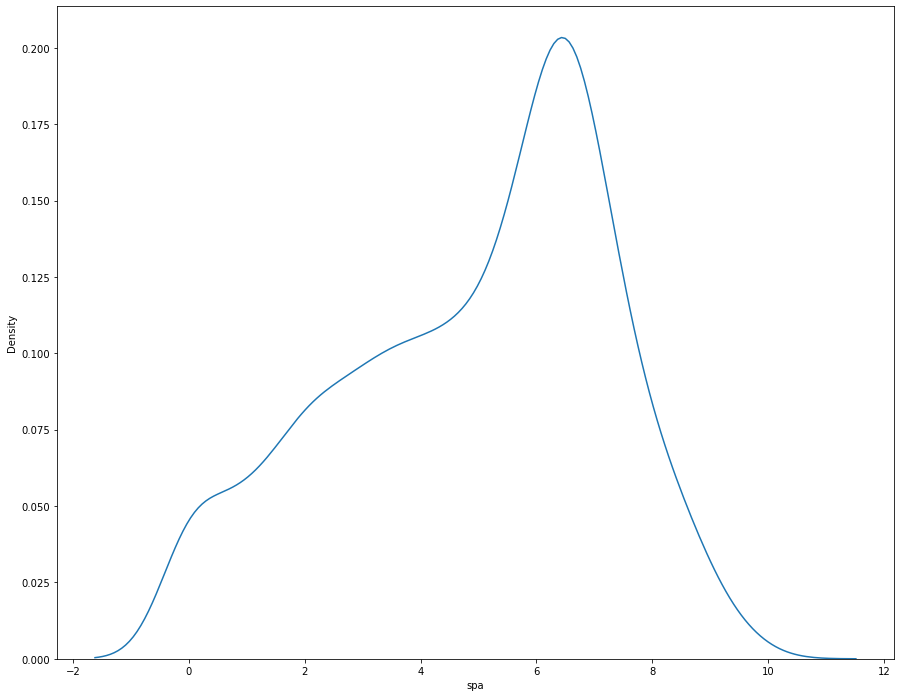

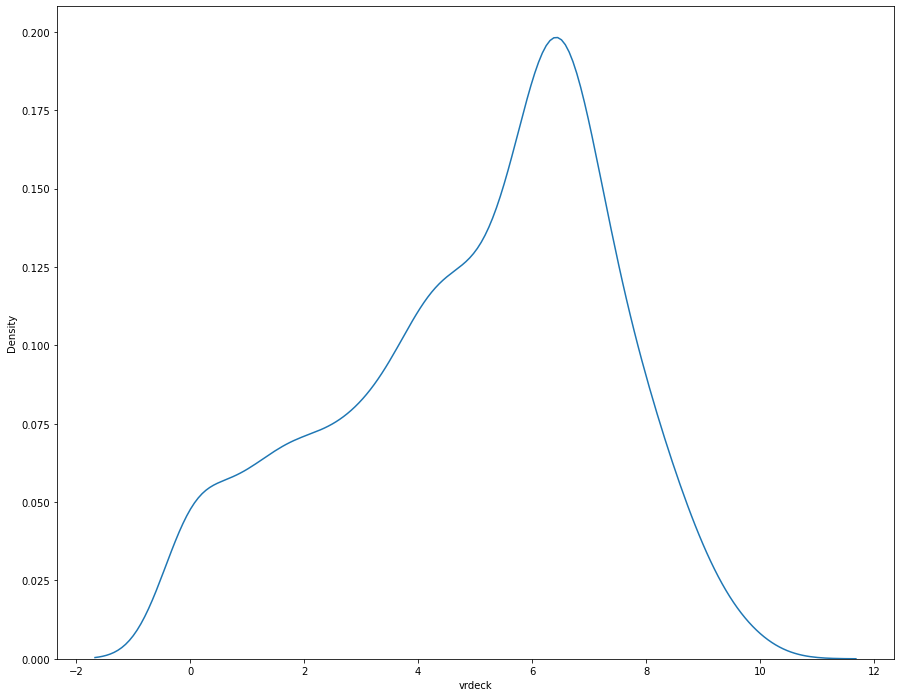

In [387]:
test_x = prepare(test)

In [388]:
test_x

array([[-0.81725903,  1.36468464,  0.62054498, ...,  0.93241421,
         0.9681811 , -0.27730039],
       [-0.81725903, -0.73277002,  0.62054498, ...,  0.36929925,
         0.9681811 , -0.06584859],
       [ 0.44038529,  1.36468464, -1.83368499, ..., -1.32004562,
         0.9681811 , -1.89777212],
       ...,
       [ 1.6980296 ,  1.36468464, -1.83368499, ..., -0.75693067,
        -1.03286462, -0.28520513],
       [ 0.44038529, -0.73277002,  0.62054498, ..., -0.75693067,
        -1.03286462, -0.28322894],
       [-0.81725903,  1.36468464, -0.60657001, ...,  0.93241421,
         0.9681811 , -1.0025603 ]])

In [390]:
log.predict(test_x)

array([1., 0., 1., ..., 1., 1., 1.])

In [391]:
rnd_frst.predict(test_x)

array([1., 0., 1., ..., 1., 0., 1.])